# Notebook S1

This notebook takes you through the steps to get the local workflow set up.

We start by specifying all parameters- you only need to change the ones you plan to use.

We then use these specified parameters to write the config file in JSON format. 

We then download waveforms into miniseed files using the download_mseeds script and the config file we just created.

We can also then create templates for template matching using a starting catalog in QuakeML format and the config file we created.

In [2]:
import obspy
from obspy.clients.fdsn.client import Client
import json
import sys
import os
import pandas as pd

## Specify station information

In [3]:
network = 'NV' 
station = '*'
channels = 'HN*,EH*,HH*'

starttime = obspy.UTCDateTime(2017,1,1)
endtime = obspy.UTCDateTime(2020,1,1)

minlat = 47.5
maxlat = 48.5
minlon = -129.15
maxlon = -129.05 

client = Client('IRIS')

sta_data = client.get_stations(starttime=starttime,endtime=endtime,network=network,
                         station=station,minlatitude=minlat,minlongitude=minlon,
                         maxlatitude=maxlat,maxlongitude=maxlon,channel=channels)


In [4]:
# Then make csv for association, and stations list for other tasks

station_csv_path = '/Users/Zoe/seismicloud/data/stations.csv'

network = []
stations = []
locations = []
sta_lats = []
sta_lons = []
sta_elev = []
for net in sta_data:
    for sta in net:
        network.append(net.code)
        stations.append(sta.code)
        locations.append('')
        sta_lats.append(sta.latitude)
        sta_lons.append(sta.longitude)
        sta_elev.append(sta.elevation)
station_dict = {'network':network,'station':stations,'location':locations,'latitude':sta_lats,'longitude':sta_lons,'elevation':sta_elev}
station_df = pd.DataFrame.from_dict(station_dict)
station_df.to_csv(station_csv_path)

## Make JSON config file

#### Below specify path names, network and station information.

In [5]:
# Path to your python environment:
interpreter = "/home/zkrauss/mambaforge/envs/alaska-ml/bin/python"
interpreter = '/Users/zoekrauss/anaconda3/envs/alaska-ml/bin/python'
# Path to where waveform data in mseed format will be/is stored:
mseed_path = "/Users/zoekrauss/seismicloud/waveforms/" 
# Path to where eqcorrscan templates in .tgz will be/are stored:
templates_path = "data/templates/test_templates.tgz"
# Path to output eqcorrscan detections:
detections_path = "data/detections/"
# Path to output EQTransformer picks:
picks_path = "data/picks/"
# Path to folder that stores job lists:
jobs_path = "jobs/"
# Path to the starting catalog in QuakeML format that can be used to create eqcorrscan templates:
starting_cat_path = "data/catalogs/endquakes_2017.xml"

        
workflow = {'interpreter':interpreter,'mseed_path':mseed_path,'templates_path':templates_path,'detections_path':detections_path,
               'jobs_path':jobs_path,'picks_path':picks_path,'starting_cat_path':starting_cat_path,
               'stations':stations,'network':network}
        

#### Below specify path to logs.

In [6]:
verbose = 0
# Whether to just append to preexisting logs or write over them:
appendlog = False
# Path to where logs should be output:
logs_path = 'logs/'

log = {'verbose':verbose,'appendlog':appendlog,'logs_path':logs_path}

#### Specify the below for use with the download_mseeds.py script

In [7]:
# Path to where you want the mseeds to be stored:
# (redundant with the workflow dictionary, but allows new downloads)
mseed_path = "/Users/Zoe/seismicloud/waveforms/" 
mseed_path = '/Users/zoekrauss/seismicloud/waveforms/'

# Below also redundant with the workflow dictionary, but specify again more specifically here
# with channel names:
stations = ["KEMF","NCHR","ENWF","KEMO"]
network = "NV"
channels = "EH*,HH*"

# Beginning and end timestamps for when you want to download data for:
# (keep them in this string format!)
t1 = "2017,6,1,0,0,0"
t2 = "2017,6,3,0,0,0"

# Whether or not you want to resample all data after the download and before writing it,
# and what sampling rate to resample to if so:
resamp = "True"
samp_rate = 200

mseed_download = {'mseed_path':mseed_path,'stations':stations,'network':network,
                  'channels':channels,'t1':t1,'t2':t2,
                 'resamp':resamp,'samp_rate':samp_rate}

#### Specify below for template matching, template parameters

In [8]:
# Parameters of the templates themselves
# Following EQCorrscan documentation
lowcut = 8.0   # lowpass frequency
highcut = 35.0 # highpass frequency
filt_order = 4
data_pad = 20.0
samp_rate = 200.0
length = 0.5
prepick = 0.05
process_len = 86400
min_snr = 0.1
swin = 'all'

templates = {'lowcut':lowcut,'highcut':highcut,'filt_order':filt_order,
            'data_pad':data_pad,'samp_rate':samp_rate,'length':length,
            'prepick':prepick,'process_len':process_len,'min_snr':min_snr,
            'swin':swin}

# Filters for the starting catalog, if using the catalog to create templates
min_lat = 47.9
max_lat = 48.05
min_lon = -129.15
max_lon = -129.05
min_time = "2017,6,1,0,0,0"
max_time = "2017,6,3,0,0,0"
min_magnitude = 0.5
max_magnitude = "NaN"

starting_catalog = {'min_lat':min_lat,'max_lat':max_lat,'min_lon':min_lon,
                   'max_lon':max_lon,'min_time':min_time,'max_time':max_time,
                   'min_magnitude':min_magnitude,'max_magnitude':max_magnitude}

# Thresholds of template matching, following EQCorrscan
threshold = 8
threshold_type = 'MAD'
trig_int = 1

template_matching = {'threshold':threshold,'threshold_type':threshold_type,
                    'trig_int':trig_int}

#### Specify below for use of the ML branch with SeisBench

In [9]:
# Picking parameters

hourly_detection = False
pretrained = "original"
max_gap = 20

# Default arguments
overlap = 5000
blinding = [1000,1000]
default_args = {'overlap':overlap,'blinding':blinding}

# Detection arguments
P_threshold = 0.1
S_threshold = 0.1
detection_args = {'P_threshold':P_threshold,'S_threshold':S_threshold}

picking = {'hourly_detection':hourly_detection,'pretrained':pretrained,'max_gap':max_gap,
        'default_args':default_args,'detection_args':detection_args}

In [10]:
# Association parameters

stations = "/Users/Zoe/seismicloud/data/stations.csv"
stations = '/Users/zoekrauss/seismicloud/data/stations.csv'

# Path to directory you want the output catalog to be written
catalog_path = '/Users/Zoe/seismicloud/data/catalogs/'
dims = ["x(km)", "y(km)", "z(km)"]
use_dbscan = False
use_amplitude = False
x_km = [-3800, -3600]
y_km = [17200, 17400]
z_km = [-20, 20]
center = [-129, 47.5]
vel = {'p':7.0,'s':4.0}
method = 'BGMM'
oversample_factor = 5
min_picks_per_eq = 1
max_sigma11 = 2.0
max_sigma22 = 1.0
max_sigma12 = 1.0

association = {'stations':stations,'catalog_path':catalog_path,'dims':dims,'use_dbscan':use_dbscan,'use_amplitude':use_amplitude,
              'x(km)':x_km,'y(km)':y_km,'z(km)':z_km,'center':center,'vel':vel,
              'method':method,'oversample_factor':oversample_factor,
              'min_picks_per_eq':min_picks_per_eq,'max_sigma11':max_sigma11,
              'max_sigma22':max_sigma22,'max_sigma12':max_sigma12}

In [11]:
model = {'picking':picking,'association':association}

#### Combine all sets of parameters into a large dictionary

In [13]:
sum_dict = {'workflow':workflow,'log':log,'mseed_download':mseed_download,
            'templates':templates,'starting_catalog':starting_catalog,
           'template_matching':template_matching,
           'model':model}

## Write to a JSON file

In [16]:
config_path = "/Users/zoekrauss/seismicloud/configs/config_sample.json"

In [17]:
# Serializing json
json_object = json.dumps(sum_dict, indent=4)
 
# Writing to sample.json
with open(config_path, "w") as outfile:
    outfile.write(json_object)

## Download mseeds
We can do so using the download_mseeds script, which takes the config json file that we just created as an input argument.
So, where the mseeds will be written to, which stations and networks they will be for, and whether or not they will be resampled must be defined in the config file.

In [11]:
interpreter_path = sys.executable
script_path = '/Users/zoekrauss/seismicloud/scripts/download_mseeds.py'
command = ' '.join([interpreter_path,script_path,'--config',config_path])

In [12]:
command

'/opt/anaconda3/envs/alaska-ml/bin/python /Users/zoekrauss/seismicloud/scripts/download_mseeds.py --config /Users/zoekrauss/seismicloud/configs/config_sample.json'

In [20]:
# You can run the script with input arguments here, or copy and paste the command into a terminal
os.system(command)

/Users/zoekrauss/anaconda3/envs/alaska-ml/lib/python3.9/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


2017-06-01T00:00:00.000000Z
Written!
Written!
Written!
Written!
2017-06-02T00:00:00.000000Z
Written!
Written!
Written!
Written!


0

## Make templates

In [13]:
script_path = '/Users/Zoe/seismicloud/scripts/template_matching/make_templates.py'
command = ' '.join([interpreter_path,script_path,'--config',config_path])

In [14]:
command

'/opt/anaconda3/envs/alaska-ml/bin/python /Users/Zoe/seismicloud/scripts/template_matching/make_templates.py --config /Users/zoekrauss/seismicloud/configs/config_sample.json'

In [ ]:
os.system(command)

In [20]:
# You can look at the created templates as follows:
from eqcorrscan.core.match_filter.tribe import Tribe
templates = Tribe().read(templates_path)

In [21]:
# See how many templates were created:
templates

Tribe of 77 templates

In [22]:
# You can look at each template by indexing through the object:
templates[0]

Template 515146: 
	 6 channels;
	 lowcut: 8.0 Hz;
	 highcut: 35.0 Hz;
	 sampling rate 200.0 Hz;
	 filter order: 4; 
	 process length: 86400.0 s

In [26]:
# You can see which original event from the starting catalog each template is built from by accessing 
# its event attribute:
templates[0].event

Event:	2017-06-01T20:05:38.782000Z | +48.028, -129.070 | 1.2387 Mw

	 resource_id: ResourceIdentifier(id="quakeml:/Event/NV/515146")
	  event_type: 'earthquake'
	        ---------
	    comments: 1 Elements
	       picks: 6 Elements
	     origins: 1 Elements
	  magnitudes: 1 Elements

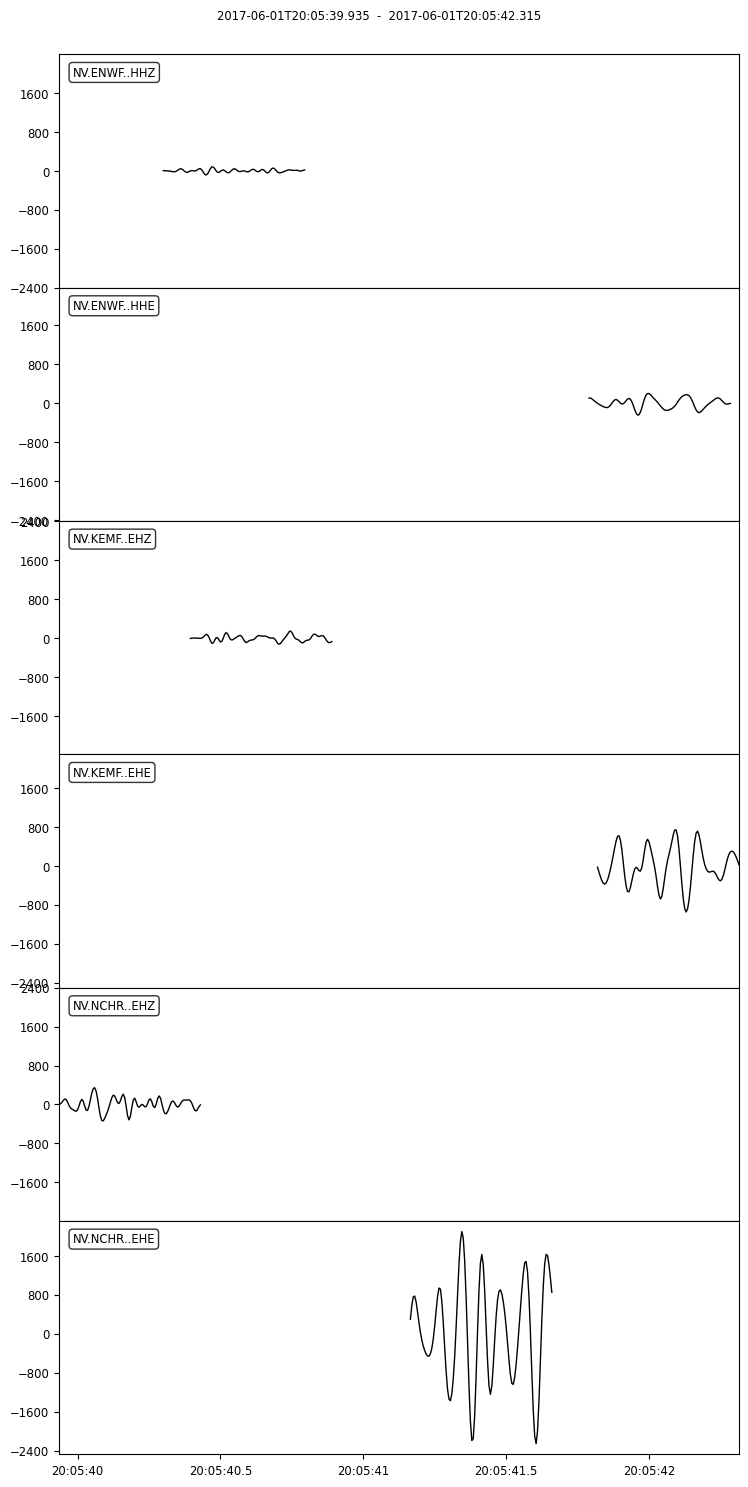

In [25]:
# You can plot the template by accessing its stream attribute:
templates[0].st.plot();